# Deep Autoencoders

In this notebook, we will explore autoencoders to perform the following three tasks

- Data compression
- Data generation
- Data interpolation

We will be using [MNIST digit dataset](https://en.wikipedia.org/wiki/MNIST_database), which is easily available through [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.MNIST). 

We will explore the following type of autoencoders:
- Sparse Autoencoder with L1 penalty
- Sparse Autoencoder with KL penalty
- Contractive Autoencoder 
- $\beta$-Variational Autoencoder

### Setup

For this tutorial, we will need the following python packages 

1. numpy
2. matplotlib
3. torch
4. torchvision

Please follow the instructions [here](https://pytorch.org/) to install the last two libraries. 

In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from matplotlib.lines import Line2D

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

# it is a good practice to define `device` globally
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)


Using GPU: cuda


### Data

PyTorch has simple-to-use functions that downloads and loads the datasets. We will use these functions to streamline our deep learning pipeline.

Checkout other image datasets at [torch.datasets](https://pytorch.org/vision/stable/datasets.html).

In [2]:
# download data in data folder. It will create this folder if it doesn't exist
torchvision.datasets.MNIST(root="./data/", download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

### Explore Data

We will be carrying out simple investigations as we did in the practical of denoising autoencoders. 
Specifically, we are interested in finding out the following :

How does the data look like?

- What is the `type` of data?
- What does each element of data represent?
- What are the constituent parts of each element?
- How is the image represented?
- What do we use to plot an image?
- How do we use the image in our model?

In [3]:
# load data 
data = torchvision.datasets.MNIST(root="./data/", train=True) # only load training data

In [4]:
print("Type of data is the class\n", type(data))
print("\nEach element of the data is\n", type(data[0]))
print("\nA single element is\n", data[0],"\n\nfirst element is the image and the second element is the category")

Type of data is the class
 <class 'torchvision.datasets.mnist.MNIST'>

Each element of the data is
 <class 'tuple'>

A single element is
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F329830F690>, 5) 

first element is the image and the second element is the category


### Image data

We know that the image data is present in `PIL.Image.Image` format. We need to convert it to array of pixel values to operate on it. We will also be displaying these images. `matplotlib.pyplot` has a simple function `plt.imshow()` to display matrix as an image.

Raw image to tensor shape: torch.Size([1, 28, 28])
2D image tensor shape: torch.Size([28, 28])


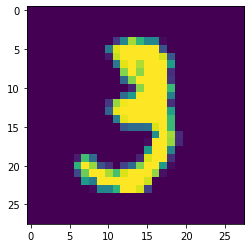

In [5]:
img = transforms.ToTensor()(data[10][0])
print(f"Raw image to tensor shape: {img.shape}")

# To plot this, we need a 2D array, so we use squeeze_(0) to remove first dimension
img = img.squeeze_(0)
print(f"2D image tensor shape: {img.shape}")

# how to display the image 
plt.imshow(img)

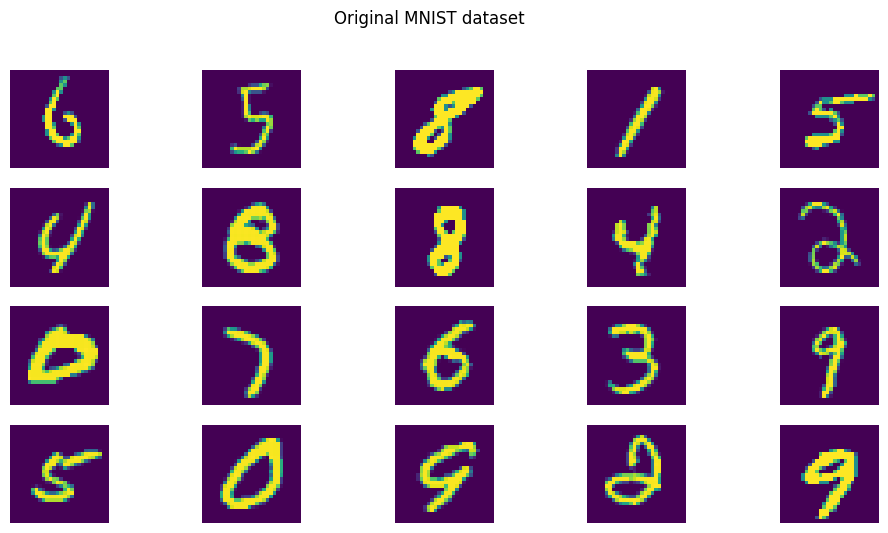

In [6]:
# visualize
n_samples = len(data)
n_vis = 20

nrows = 4
ncols = math.ceil(n_vis/nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6), dpi=100)

idxs = np.random.randint(low=0, high=n_samples, size=n_vis)

for i, idx in enumerate(idxs):
    ax = axs[i%nrows, i//nrows]
    img = transforms.ToTensor()(data[idx][0]).squeeze_(0)
    ax.imshow(img)
    ax.axis('off')

_ = fig.suptitle(f"Original MNIST dataset")


In [7]:
input_shape = img.shape

## Data Compression: Simple setup & Vanilla Deep Autoencoder

We are interested in finding a compact representation for digits in our dataset. 
We will choose our latent dimension to be a 2D plane so that it's easy to visualize. 
However, depending on the usecase (e.g, classification, semi-supervised classification, etc.), one might choose a higher dimensional latent space.

In this section, will be setting up our code to test it on various autoencoders discussed in the lessons. 
We will be using a vailla Autoencoder to build our necessary functions, and then we will reuse these functions with different autoencoders.

To do this, we will build an autoencoder that comprises of an encoder and a decoder. 

In the following block of code, we will be implementing a simple **deep autoencoder**.
We will be using linear layers to process our images, although you are free to chose the architecture you like.
It consists of two blocks -
- Encoder
- Decoder

We will be following the same pattern to implement other autoencoders in the rest of the tutorial.

In [8]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(DeepAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.in_dim = input_shape[0] * input_shape[1]
        
        # encoder 
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, self.in_dim),
            nn.Sigmoid()
        )
        
    
    def encode(self, x):
        x = x.reshape(-1, self.in_dim)
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z).reshape(-1, self.input_shape[0], self.input_shape[1])

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

We need to write a function to fetch the memory statistics of our model.
While building different autoencoder models, it will be important to ensure they have all similar number of learnable parameters. This will ensure fair comparison of their performance.

In [9]:
def mem_size(model):
    """
    Get model size in GB (as str: "N GB")
    """
    mem_params = sum(
        [param.nelement() * param.element_size() for param in model.parameters()]
    )
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs
    return f"{mem / 1e9:.4f} GB"

def num_params(model):
    """
    Print number of parameters in model's named children
    and total
    """
    s = "Number of parameters:\n"
    n_params = 0
    for name, child in model.named_children():
        n = sum(p.numel() for p in child.parameters())
        s += f"  • {name:<15}: {n}\n"
        n_params += n
    s += f"{'total':<19}: {n_params}"

    return s

def pp_model_summary(model):
    print(num_params(model))
    print(f"{'Total memory':<18} : {mem_size(model)}")

In [10]:
# test
model_ae = DeepAutoencoder(input_shape, 2)
pp_model_summary(model_ae)

Number of parameters:
  • encoder        : 52882
  • decoder        : 53664
total              : 106546
Total memory       : 0.0004 GB


### Dataset loading

PyTorch uses `torch.utils.data.Dataset` class to load data in parallel on multiple CPUs. It enables faster loading of the batch of data. It then uses `torch.utils.data.DataLoader` to combine these loaded data points together into a batch. These batches are then used as an input to the models.

For this reason, we need to customize `__len__` and `__getitem__` functions in the class. This will help us do any necessary preprocessing on the images before using them as an input to the model.

In [11]:
# create a dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = transforms.ToTensor()(self.data[index][0]).squeeze_(0)
        label = self.data[index][1] # to be used for visualization
        return img, label

### Loss 

We will create a function that will take following inputs:

1. An autoencoder instance
2. `torch.utils.data.DataLoader` instance 
3. loss function to compute loss based on the inputs 
4. optimizer (optional)

This function returns the mean loss on this data. We will be redesigning parts of this model further. 

In [12]:
def process(model, data, loss_fn, optimizer=None):
    """
    Trains the `model` on `data`
    
    Args:
        model (nn.Module): model to process the data
        data (torchvision.datasets): MNIST dataset
        loss_fn (fn): how you want to compute the loss
        optimizer (torch.optim): Optimizer of choice 
    
    Returns:
        (float): mean loss 
    """
    
    n_samples = 0
    running_loss = 0
    for batch_img, _ in data:
        # transfer to GPU if avaiable
        x = batch_img.to(device)

        n_samples += x.shape[0]
        
        # compute loss 
        loss = loss_fn(model, x)
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / n_samples
        

### Train

Finally, we will be running the training for `n_epochs` number of epochs. 
Each epoch consists of doing a backward pass on the subset of training data and evaluating the model on the validation data. 

**Note**: If one is concerned with good representation of the training data only (i.e., generalization outside training data is not of concern), we need not split our dataset into train and validation. 
However, in this tutorial, we will use the validation dataset to pick a model with the best generalization error. 

We will create a function `train` to conveniently call it with various models and loss functions that we can experiment with. 

In [13]:
def train(model, loss_fn, epochs=30, append_title=""):
    """
    Trains the `model` using `process`
    
    Args:
        model (nn.Module): model to process the data
        data (torchvision.datasets): MNIST dataset
        optimizer (torch.optim): Optimizer of choice 
        process (fn): function defining how each epoch is handled
    
    Returns:
        best_model (nn.Module): returns the model with the best training loss 
        loss_plot (matplotlib.subplots): a plot for how training loss varied over the epochs
    """
    # create a model directory to store the best model
    model_dir = pathlib.Path("./models").resolve()
    if not model_dir.exists():
        model_dir.mkdir()

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

    n_epochs = epochs
    epoch_size=200
    batch_size=128

    best_train_loss = np.inf
    train_losses = []
    for epoch in range(n_epochs):
        print(f"@ epoch {epoch}", end="")

        # training loss
        idxs = rng.choice(len(data), epoch_size * batch_size, replace=True)
        train_data = torch.utils.data.DataLoader(Dataset([data[idx] for idx in idxs]), batch_size=batch_size, num_workers=4)
        train_loss = process(model, train_data, loss_fn, optimizer)
        
        # save
        if train_loss < best_train_loss:
            best_train_loss = train_loss 
            torch.save(model.state_dict(), model_dir / f"best_{model.__class__.__name__}_L_{model.latent_dim}{append_title}.ckpt")
    
        # log
        train_losses.append(train_loss)
        print(f"\ttrain_loss: {train_loss: .7f}")

    # load the best model
    model = model.__class__(model.input_shape, model.latent_dim)
    model.load_state_dict(torch.load(model_dir / f"best_{model.__class__.__name__}_L_{model.latent_dim}{append_title}.ckpt"))
    model = model.to(device)

    return model, train_losses


In [14]:
# a function to create a string out of model; to be used as a title for visualizing
def get_model_title(model):
    """returns the string title for model"""
    return f"{model.__class__.__name__} (latent_dim={model.latent_dim})"


def visualize_losses(train_losses, title=""):
    """
    Visualize the loss trajectory 
    
    Args:
        train_losses (list): elements are float
        val_losses (list): elements are float
        title (str): title to appear at the top of the figure
    """
    # plot losses
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

    axs.plot(train_losses, color="#BDD9BF", marker="x", label="Train loss")
#     axs.plot(val_losses, color="#A997DF", marker="o", label="Val loss")
    axs.set_xlabel("Epochs", fontsize=20)
    axs.legend(prop={"size":15})

    # tick size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    fig.suptitle(title)

### Visualize Reconstructed images

Here we will write a function that can help us visualize the quality of reconstruction 


In [15]:
def vis_reconstructed_images(model, append_title=""):
    """
    Randomly samples images and compare them with reconstructed imates usiing `model`
    
    Args:
        model (nn.Module): model to use to reconstruct the images
    """
    model = model.cpu()
    n_samples = len(data)
    n_vis = 20

    nrows = 4
    ncols = math.ceil(n_vis/nrows)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8), dpi=100)

    idxs = np.random.randint(low=0, high=n_samples, size=n_vis)

    for i, idx in enumerate(idxs):
        ax = axs[i%nrows, i//nrows]

        x = transforms.ToTensor()(data[idx][0]).squeeze_(0)

        with torch.no_grad():
            z, x_hat = model(x)
            x_hat = x_hat.squeeze_(0)

        filler =  np.ones((img.shape[0], 10))
        concat_img = np.concatenate((x, filler, x_hat), axis=1)

        ax.imshow(concat_img)
        ax.axis('off')

    title = f"{get_model_title(model)}{append_title}"
    _ = fig.suptitle(f"Original MNIST & recostructed images by {title} ")
    
    fig.savefig(f"images/recons_imgs_{title}.png")


### Visualize embeddings

Here we will write a function that can help us visualize 2D embeddings of points

In [16]:
def get_latent_representations(model, n=1000, seed=1):
    """
    Randomly samples data from x_train, and returns their encoded representation using `model`
    
    Args:
        model (nn.Module): model to call `encode` on
        n (int): number of samples to use 
    
    Returns:
        points (list): encoded representation of random samples 
        labels (list): corresponding labels
    """
    model = model.cpu()
    n_samples = len(data)
     
    np.random.seed(seed)
    idxs = np.random.randint(low=0, high=n_samples, size=n)

    # encode
    points = []
    labels = []
    for idx in idxs:
        
        img, y = data[idx]
        img =  transforms.ToTensor()(img).squeeze_(0)
        
        with torch.no_grad():
            z = model.encode(img).squeeze_(0).numpy().tolist()

        points.append(z)
        labels.append(y)
    
    return points, labels


# use t-SNE for projecting to 2d: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
def project_points_on_2D(points):
    """
    Returns the 2D projection of `points`
    
    Args:
        poitns (list): some high dimensional points 
    
    Returns:
        (list): 2D representation of the points 
    """
    if len(points[0]) <=2 :
        return list(points)

    from sklearn.manifold import TSNE  
    points = TSNE(n_components=2).fit_transform(np.array(points))
    return points.tolist()
    

def vis2D(model, n=6000, seed=1, append_title=""):
    """
    visualizes 2D representation of the points encoded using `model`.

    Args:
        model (nn.Module): model to call `encode` on
        n (int): number of samples to use     
    """
    points, labels = get_latent_representations(model, n, seed)
    
    if len(points[0]) > 2:
        points = project_points_on_2D(points)
    
    # visualize
    COLORS = ['#208ea3', '#62bb35', '#8d9f9b', '#e8384f', '#4178bc', '#fd817d', '#fdae33', '#a4c61a', '#37a862', '#7471f6', "#ea4e9d"]
    colormap = {i:c for i,c in enumerate(COLORS)}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8), dpi=100)

    x, y = zip(*points)
    colors = [colormap[l] for l in labels]
    ax.scatter(x, y, s=20, label=labels, c=colors)
    
    # legend
    legend = []
    for i, c in colormap.items():
        legend.append(Line2D([0, 1], [0, 0], color=c, label=f"{i}", linewidth=5))
    
    ax.legend(handles=legend, ncol=1, loc="upper right", fontsize=15, fancybox=True)
                          
     # title
    title = f"{get_model_title(model)}{append_title}"
    _ = fig.suptitle(f"Latent representation of digits by {title} ")
    fig.savefig(f"images/vis2d_{title}.png")
    

### Full setup

Finally, we only need to use the above defined functions in the following way to check the performance of these models.

In [17]:
# our final setup (vanilla AE)
def reconstruction_loss(model, x):
    z, x_hat = model(x)
    return nn.BCELoss(reduction="sum")(x_hat, x) 

In [18]:
model_deepae, losses = train(DeepAutoencoder(input_shape, 2), reconstruction_loss, epochs=30)

@ epoch 0	train_loss:  259.0258532
@ epoch 1	train_loss:  195.8383048
@ epoch 2	train_loss:  182.1310158
@ epoch 3	train_loss:  175.1158627
@ epoch 4	train_loss:  172.3203966
@ epoch 5	train_loss:  167.5732262
@ epoch 6	train_loss:  162.1455909
@ epoch 7	train_loss:  159.8230414
@ epoch 8	train_loss:  156.9454025
@ epoch 9	train_loss:  155.6188171
@ epoch 10	train_loss:  154.6280393
@ epoch 11	train_loss:  152.8035545
@ epoch 12	train_loss:  151.6336966
@ epoch 13	train_loss:  151.3088992
@ epoch 14	train_loss:  149.8450508
@ epoch 15	train_loss:  150.3754742
@ epoch 16	train_loss:  148.0135738
@ epoch 17	train_loss:  147.4764351
@ epoch 18	train_loss:  147.6330389
@ epoch 19	train_loss:  147.1632935
@ epoch 20	train_loss:  146.6522166
@ epoch 21	train_loss:  146.3733444
@ epoch 22	train_loss:  145.7351781
@ epoch 23	train_loss:  145.8057564
@ epoch 24	train_loss:  145.2915800
@ epoch 25	train_loss:  145.1282550
@ epoch 26	train_loss:  144.8719188
@ epoch 27	train_loss:  144.6043841
@ 

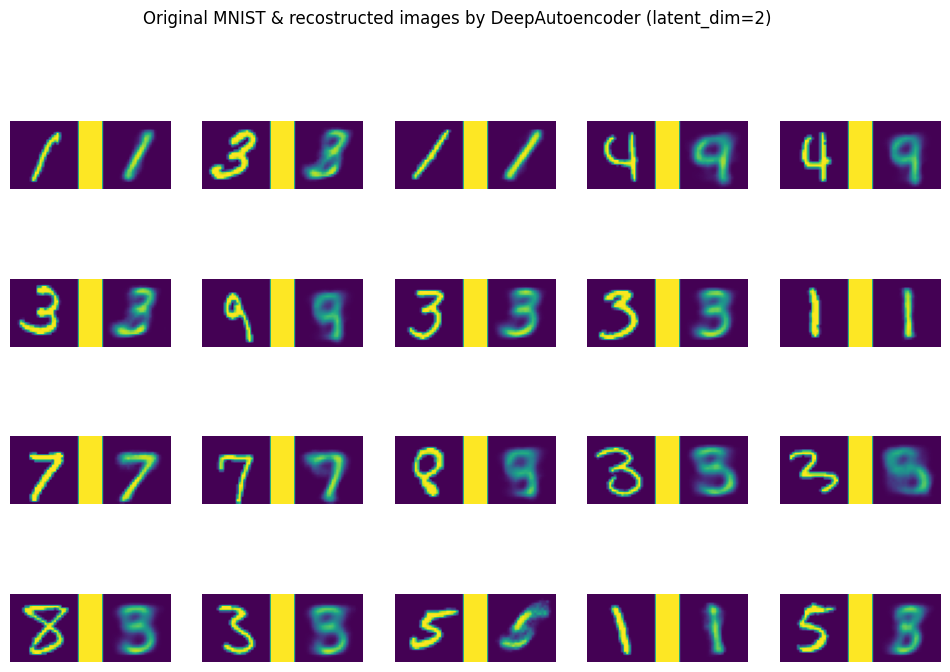

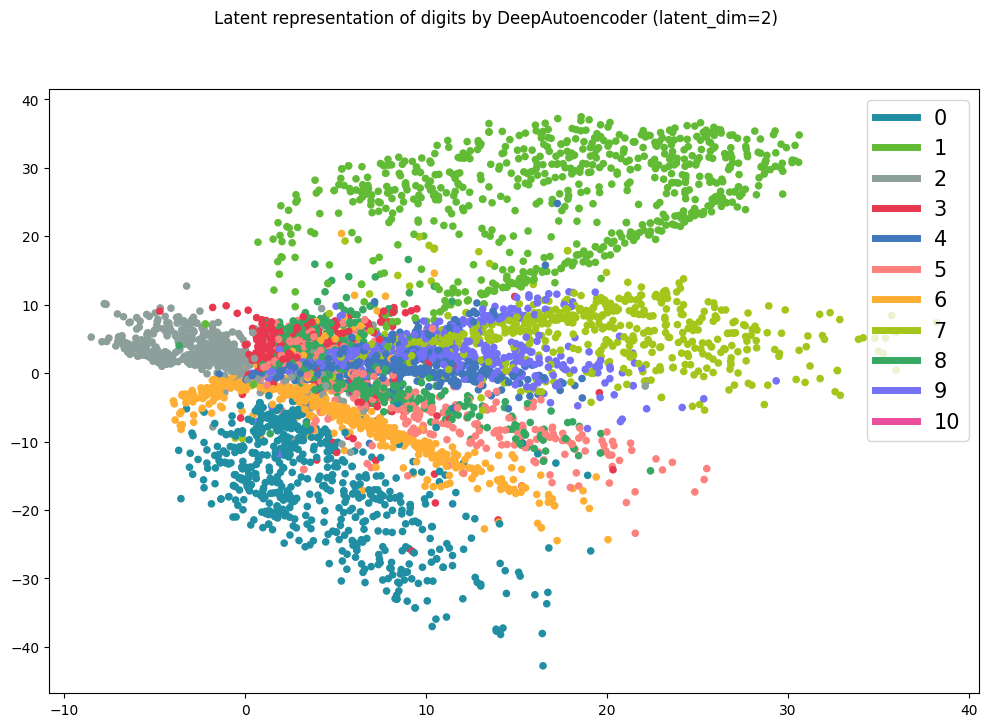

In [19]:
# visualize
vis_reconstructed_images(model_deepae)
vis2D(model_deepae)

Here we observe that representations of the similar digits (e.g., 4 and 9) are situated next to each other. 
Note that the clusters are spread across the 2D plane, thereby resulting in wide gaps between them (e.g,. 1 and 7). 
We will soon see how interpolation with DeepAutoencoders look like. 

### Data Compression: Sparse Autoencoder - L1 penalty

Recall that sparse autoencoders penalize the hidden activations. To do this, we will need to extract the individuals activations, and add their appropriate term to the loss function.

Thus, we need to write a function that can give us access to the individual processing of layers. This could be done while contructing the neural network itself (e.g, in the DeepAutoencoder class), however, we will make use of post-processing functions to do this. 

In [20]:
# get all layers : https://discuss.pytorch.org/t/module-children-vs-module-modules/4551/6
def remove_sequential(network, all_layers=[]):
    for layer in network.children():
        if type(layer) == nn.Sequential: # if sequential layer, apply recursively to layers in sequential layer
            remove_sequential(layer, all_layers)
        if list(layer.children()) == []: # if leaf node, add it to list
            all_layers.append(layer)
    
    return all_layers

In [21]:
class SparseAutoencoder(DeepAutoencoder):
    def __init__(self, input_shape, latent_dim):
        super().__init__(input_shape, latent_dim)
        
        # we will need these layers to penalize the activations
        self.encoder_layers = remove_sequential(self.encoder, [])
        self.decoder_layers = remove_sequential(self.decoder, [])

In [22]:
# check the number of parameters; we will keep the params around 105K
model = SparseAutoencoder(input_shape, 64)
pp_model_summary(model)

Number of parameters:
  • encoder        : 52882
  • decoder        : 53664
total              : 106546
Total memory       : 0.0004 GB


In [23]:
def sparse_autoencoder_loss(model, x_in, activation_loss_type="l1", penalty_reg=1e-5, rho=0.4):
    """
    Evaluates input as well as computes loss function at the same time. 
    
    Args:
        model (nn.Module): model to use. should be of instance SparseAutoencoder
        x (torch.tensor): input
        penalty_type (str): type of penalty to use, e.g., l1 or kl-divergence
        
    Returns:
        loss (torch.tensor): total loss 
    """
    encoder_depth = len(model.encoder_layers) // 2
    decoder_depth = len(model.decoder_layers) // 2
    x = x_in.reshape(-1, model.in_dim)
    
    if activation_loss_type == "l1":
        loss_fn = lambda x: torch.mean(torch.abs(x))
    elif activation_loss_type == "kl":
        loss_fn = lambda x: kl_divergence(x, rho)
    
    # encoder activations 
    activation_loss = 0
    for i in range(encoder_depth):
        fc_layer = model.encoder_layers[2*i]
        relu =  model.encoder_layers[2*i + 1]
        x = relu(fc_layer(x))
        activation_loss += loss_fn(x)

    # last layer is without relu
    fc_layer = model.encoder_layers[-1]
    x = fc_layer(x)
    
    # decoder activations; last layer's activations are not penalized because that is responsible for reconstructing images
    for i in range(decoder_depth-1):
        fc_layer = model.decoder_layers[2*i]
        relu =  model.decoder_layers[2*i + 1]
        x = relu(fc_layer(x))
        activation_loss += loss_fn(x)
    
    fc_layer = model.decoder_layers[-2]
    sigmoid = model.decoder_layers[-1]
    x = sigmoid(fc_layer(x)).reshape(-1, model.input_shape[0], model.input_shape[1]) # reconstruction 
    
    loss = nn.BCELoss(reduction="sum")(x, x_in) + penalty_reg * activation_loss
    
    return loss
    

In [24]:
# define your penalty function here 
activation_loss_type = "l1"
penalty_reg = 1e-3
append_title=f"_loss_{activation_loss_type}_{penalty_reg:.0e}"

l1_penalty = lambda model, x: sparse_autoencoder_loss(model, x, activation_loss_type=activation_loss_type, penalty_reg=penalty_reg)
model_l1_sparse, losses = train(SparseAutoencoder(input_shape, 2), l1_penalty, epochs=30, append_title=append_title)

@ epoch 0	train_loss:  272.3695934
@ epoch 1	train_loss:  195.1425864
@ epoch 2	train_loss:  183.5252870
@ epoch 3	train_loss:  174.5076365
@ epoch 4	train_loss:  170.0973509
@ epoch 5	train_loss:  165.8733104
@ epoch 6	train_loss:  163.3613481
@ epoch 7	train_loss:  160.2212537
@ epoch 8	train_loss:  159.3992554
@ epoch 9	train_loss:  158.3648038
@ epoch 10	train_loss:  156.3049339
@ epoch 11	train_loss:  154.8847045
@ epoch 12	train_loss:  153.6229128
@ epoch 13	train_loss:  153.4328179
@ epoch 14	train_loss:  152.5633212
@ epoch 15	train_loss:  151.7468706
@ epoch 16	train_loss:  151.7509801
@ epoch 17	train_loss:  150.7298859
@ epoch 18	train_loss:  149.5205402
@ epoch 19	train_loss:  149.3239899
@ epoch 20	train_loss:  148.4101003
@ epoch 21	train_loss:  148.6808641
@ epoch 22	train_loss:  148.0290062
@ epoch 23	train_loss:  147.6471975
@ epoch 24	train_loss:  147.7384892
@ epoch 25	train_loss:  147.4624222
@ epoch 26	train_loss:  147.4617051
@ epoch 27	train_loss:  147.5971163
@ 

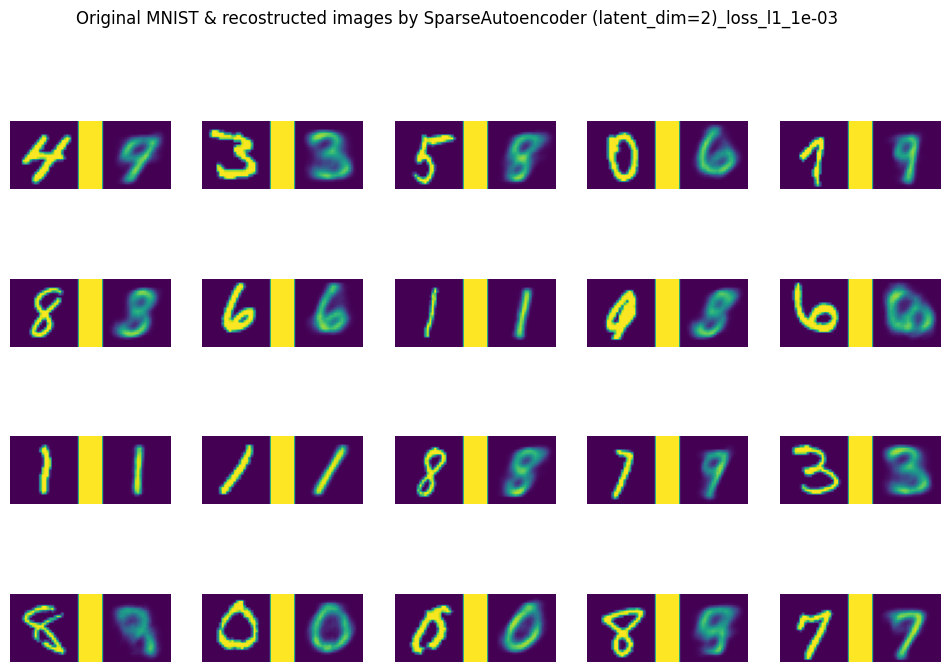

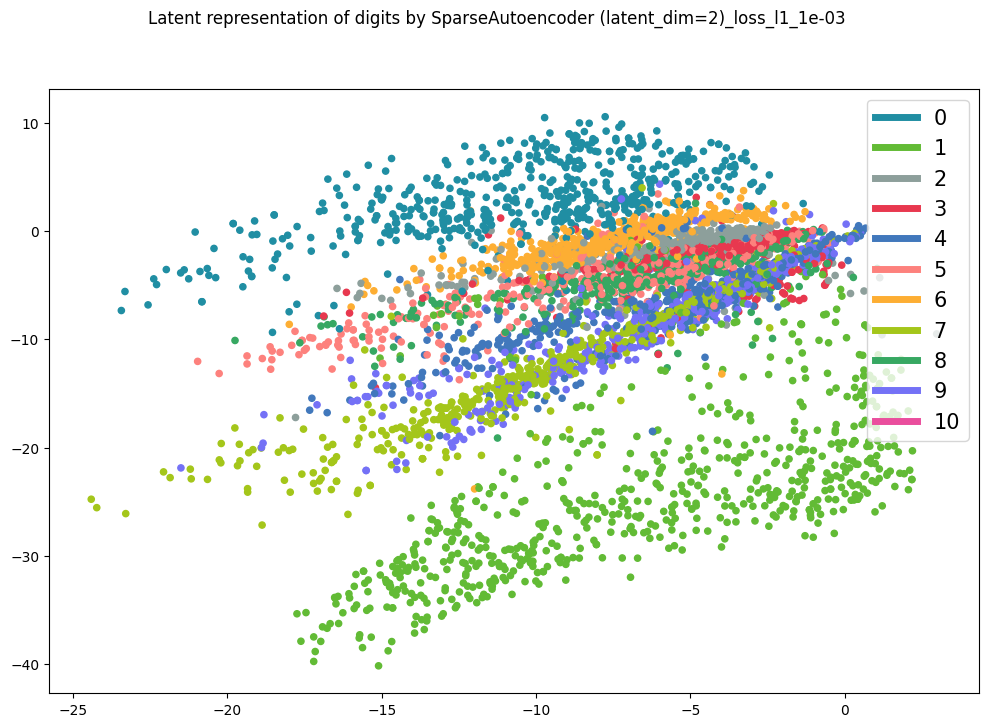

In [25]:
vis_reconstructed_images(model_l1_sparse, append_title=append_title)
vis2D(model_l1_sparse, append_title=append_title)

We observe similar clusterings as in DeepAutoencoder, however, the clusters are now more cluttered around origin.
This is expected because we are enforcing sparse distributed representations thereby allowing a handful of neurons to be active for any particular class. 
As a result, their spatial arrangement can be better managed.

### Data Compression: Sparse Autoencoder - KL Divergence 

In [26]:
def kl_divergence(x, rho):
    """
    Computes KL divergence between the activations `x` and the `fraction`
    
    Args:
        x (torch.tensor): [None, dim] hidden layer activations 
        rho (float): fraction of times these hidden layer activations are required to be active 
    
    Returns:
        (float): KL divergence 
    """
    rho_hat = torch.mean(nn.Sigmoid()(x), dim=0)
    return torch.sum(rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat)))

In [27]:
activation_loss_type = "kl"
penalty_reg = 1e-5
rho=0.4
append_title=f"_loss_{activation_loss_type}_rho_{rho:.2f}_{penalty_reg:.0e}"

kl_penalty = lambda model, x: sparse_autoencoder_loss(model, x, activation_loss_type=activation_loss_type, penalty_reg=penalty_reg, rho=rho)
model_kl_sparse, losses = train(SparseAutoencoder(input_shape, 2), kl_penalty, epochs=30, append_title=append_title)

@ epoch 0	train_loss:  261.0603734
@ epoch 1	train_loss:  192.0872421
@ epoch 2	train_loss:  178.1101578
@ epoch 3	train_loss:  172.3022298
@ epoch 4	train_loss:  168.5044589
@ epoch 5	train_loss:  165.7058086
@ epoch 6	train_loss:  163.3295512
@ epoch 7	train_loss:  161.8534805
@ epoch 8	train_loss:  160.1616310
@ epoch 9	train_loss:  158.4573147
@ epoch 10	train_loss:  157.1703566
@ epoch 11	train_loss:  155.4557841
@ epoch 12	train_loss:  154.1020038
@ epoch 13	train_loss:  153.7721549
@ epoch 14	train_loss:  152.0737710
@ epoch 15	train_loss:  151.3286908
@ epoch 16	train_loss:  151.2704441
@ epoch 17	train_loss:  150.8554875
@ epoch 18	train_loss:  150.2202708
@ epoch 19	train_loss:  150.1139229
@ epoch 20	train_loss:  149.3368565
@ epoch 21	train_loss:  148.6804688
@ epoch 22	train_loss:  148.6044331
@ epoch 23	train_loss:  147.9754417
@ epoch 24	train_loss:  147.4871819
@ epoch 25	train_loss:  147.0842321
@ epoch 26	train_loss:  146.9250669
@ epoch 27	train_loss:  145.6273869
@ 

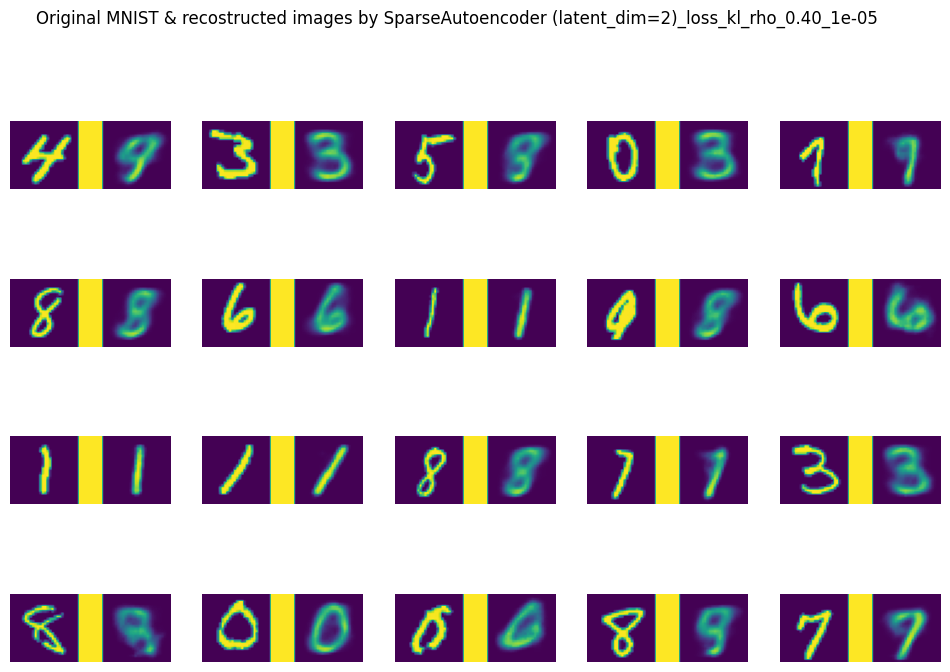

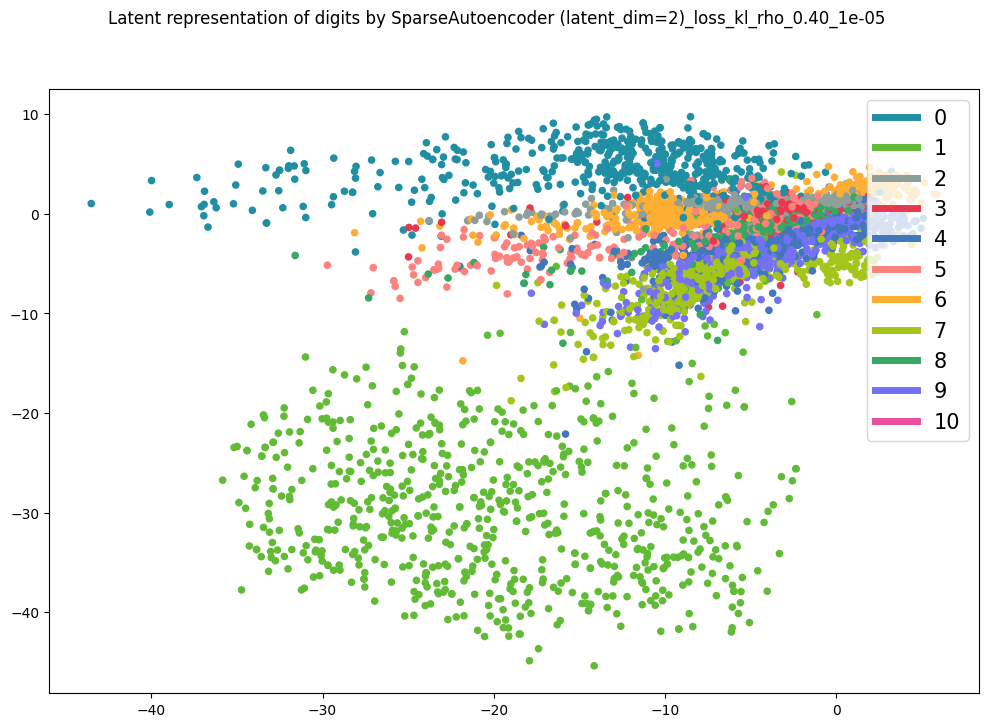

In [28]:
vis_reconstructed_images(model_kl_sparse, append_title=append_title)
vis2D(model_kl_sparse, append_title=append_title)

Once again, we observe that digits are well separated, however, the clusters are not well arranged spatially. 
This shortcoming is problematic for data interpolation. 

### Data Compression: Contractive Autoencoder

In [29]:
def cae_loss(model, x, penalty_reg=1e-5):
    """
    Computes the loss function for CAE 
    
    """
    x.requires_grad_(True) # enable grad calc. wrt inputs: dz/dx
    
    z = model.encode(x)
    x_hat = model.decode(z)
    
    contractive_loss = 0
    # each iteration computes squared norm of one row in Jacobian
    for i in range(model.latent_dim):
        unit = torch.zeros(z.shape).to(z.device)
        unit[:, i] = 1 # create a unit vector for vector-Jacobian product 
        z.backward(unit, retain_graph=True) # compute dz/dx; computes gradients wrt all Variable that requires_grad. results in storing grad info in x.grad
        contractive_loss += torch.sum(torch.mean(torch.pow(x.grad.data, 2), dim=0)) # sum is across jacobian cells, mean is across the examples in a batch
    
    x.requires_grad_(False) # computational graph is in place; no need to store any more gradients
    
    return nn.BCELoss(reduction="sum")(x_hat, x) + penalty_reg * contractive_loss

In [30]:
penalty_reg = 1e-3
cae_loss_fn = lambda model, x: cae_loss(model, x, penalty_reg)
model_cae, losses = train(DeepAutoencoder(input_shape, 2), cae_loss_fn, epochs=30, append_title=f"cae_{penalty_reg:.0e}")

@ epoch 0	train_loss:  260.3141116
@ epoch 1	train_loss:  191.6956390
@ epoch 2	train_loss:  177.8542690
@ epoch 3	train_loss:  172.0898867
@ epoch 4	train_loss:  168.9988020
@ epoch 5	train_loss:  165.6322192
@ epoch 6	train_loss:  161.3230582
@ epoch 7	train_loss:  159.3622672
@ epoch 8	train_loss:  157.3709151
@ epoch 9	train_loss:  156.4105310
@ epoch 10	train_loss:  154.8818851
@ epoch 11	train_loss:  154.2752748
@ epoch 12	train_loss:  153.1167934
@ epoch 13	train_loss:  152.2302167
@ epoch 14	train_loss:  152.2586599
@ epoch 15	train_loss:  150.8396825
@ epoch 16	train_loss:  150.1917384
@ epoch 17	train_loss:  149.7170154
@ epoch 18	train_loss:  149.2732702
@ epoch 19	train_loss:  149.4005938
@ epoch 20	train_loss:  148.5706727
@ epoch 21	train_loss:  148.2142196
@ epoch 22	train_loss:  147.2862219
@ epoch 23	train_loss:  146.7276772
@ epoch 24	train_loss:  146.2576353
@ epoch 25	train_loss:  147.0691893
@ epoch 26	train_loss:  145.3913039
@ epoch 27	train_loss:  145.2547119
@ 

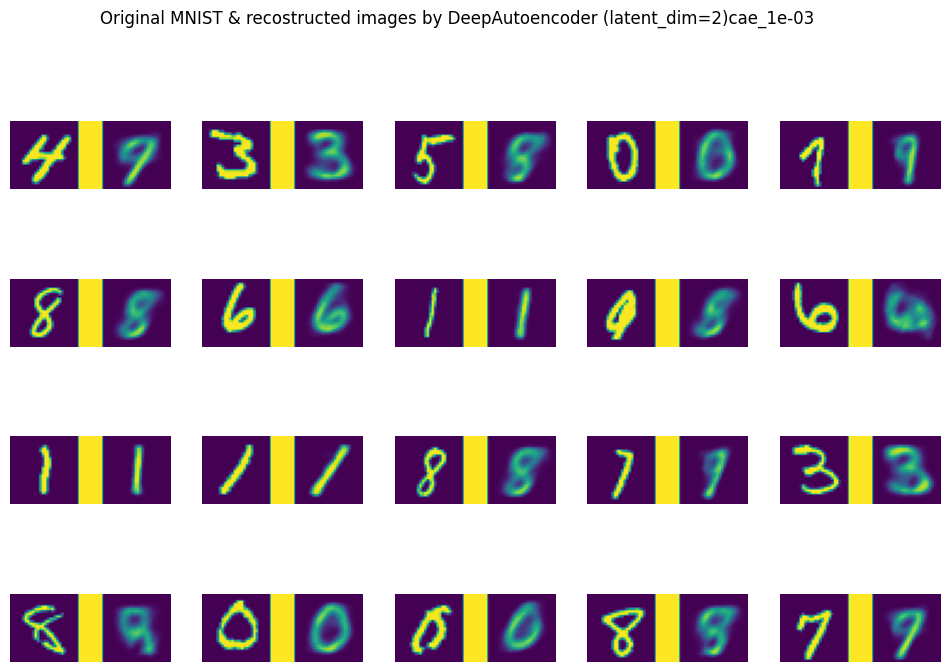

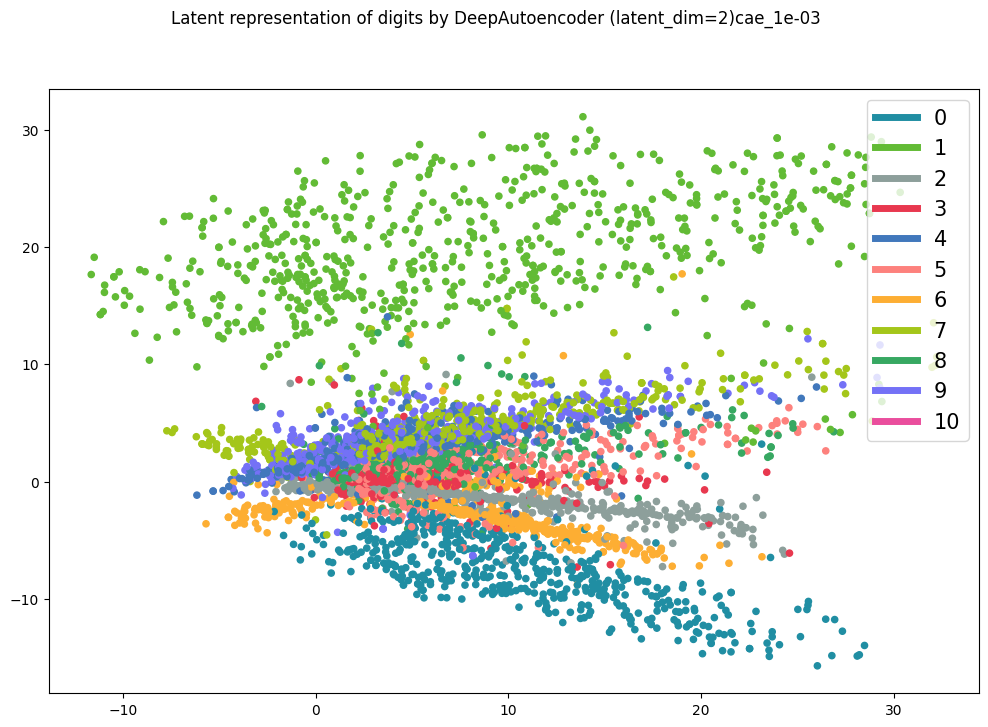

In [31]:
vis_reconstructed_images(model_cae, append_title=f"cae_{penalty_reg:.0e}")
vis2D(model_cae, append_title=f"cae_{penalty_reg:.0e}")

A contractive autoencoder seems to have a better spatial arrangement, however, a cluster is still pushed far away. 

### Data Generation: Variational Autoencoder (VAE)

In [32]:
class VariationalAutoencoder(DeepAutoencoder):
    
    def __init__(self, input_shape, latent_dim):
        super().__init__(input_shape, latent_dim)
        
        # we will overwrite the encoder 
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.mu_head = nn.Sequential(
            nn.Linear(16, 2)
        )
        
        self.log_var_head = nn.Sequential(
            nn.Linear(16, 2)
        )
        
    def encode_dist(self, x):
        x = x.reshape(-1, self.in_dim)
        _tmp_x = self.encoder(x)
        mu = self.mu_head(_tmp_x)
        log_var = self.log_var_head(_tmp_x)
        return mu, log_var
    
    def sample(self, mu, log_var):
        epsilon = torch.randn_like(mu)
        return mu + torch.exp(0.5*log_var) * epsilon
    
    def encode(self, x):
        return self.sample(*self.encode_dist(x))
        

In [33]:
model = VariationalAutoencoder(input_shape, 2)

In [34]:
pp_model_summary(model)

Number of parameters:
  • encoder        : 52848
  • decoder        : 53664
  • mu_head        : 34
  • log_var_head   : 34
total              : 106580
Total memory       : 0.0004 GB


In [35]:
def vae_loss(model, x, beta=1):
    """
    Computes vae loss
    """
    mu, log_var = model.encode_dist(x)
    x_hat = model.decode(model.sample(mu, log_var))
    
    variational_loss = -0.5 * torch.sum(log_var + 1 - torch.pow(mu, 2) - torch.exp(log_var))
    
    return nn.BCELoss(reduction="sum")(x_hat, x) + beta * variational_loss

In [36]:
model_vae = VariationalAutoencoder(input_shape, 2)

# some sources suggest warming up without KL before introducing KL term ... 
# print("Warming up without KL:\n")
# vae_loss_fn = lambda model, x: vae_loss(model, x, 0)
# model_vae, losses = train(model_vae, vae_loss_fn, epochs=10)

print("\ntraining with KL:\n")
beta = 1
vae_loss_fn = lambda model, x: vae_loss(model, x, beta)
model_vae, losses = train(model_vae, vae_loss_fn, epochs=30)


training with KL:

@ epoch 0	train_loss:  257.3225189
@ epoch 1	train_loss:  193.2546162
@ epoch 2	train_loss:  190.4156615
@ epoch 3	train_loss:  187.5459789
@ epoch 4	train_loss:  184.2749917
@ epoch 5	train_loss:  177.7576521
@ epoch 6	train_loss:  172.8527026
@ epoch 7	train_loss:  168.6581969
@ epoch 8	train_loss:  166.7014832
@ epoch 9	train_loss:  165.5846898
@ epoch 10	train_loss:  163.7346835
@ epoch 11	train_loss:  163.2149918
@ epoch 12	train_loss:  162.3914347
@ epoch 13	train_loss:  161.6456207
@ epoch 14	train_loss:  161.2340337
@ epoch 15	train_loss:  160.2792283
@ epoch 16	train_loss:  159.8100319
@ epoch 17	train_loss:  159.4439251
@ epoch 18	train_loss:  158.4921046
@ epoch 19	train_loss:  158.4168974
@ epoch 20	train_loss:  157.5402177
@ epoch 21	train_loss:  157.3630544
@ epoch 22	train_loss:  156.9844321
@ epoch 23	train_loss:  157.3425681
@ epoch 24	train_loss:  156.8799626
@ epoch 25	train_loss:  155.9698621
@ epoch 26	train_loss:  155.8134283
@ epoch 27	train_l

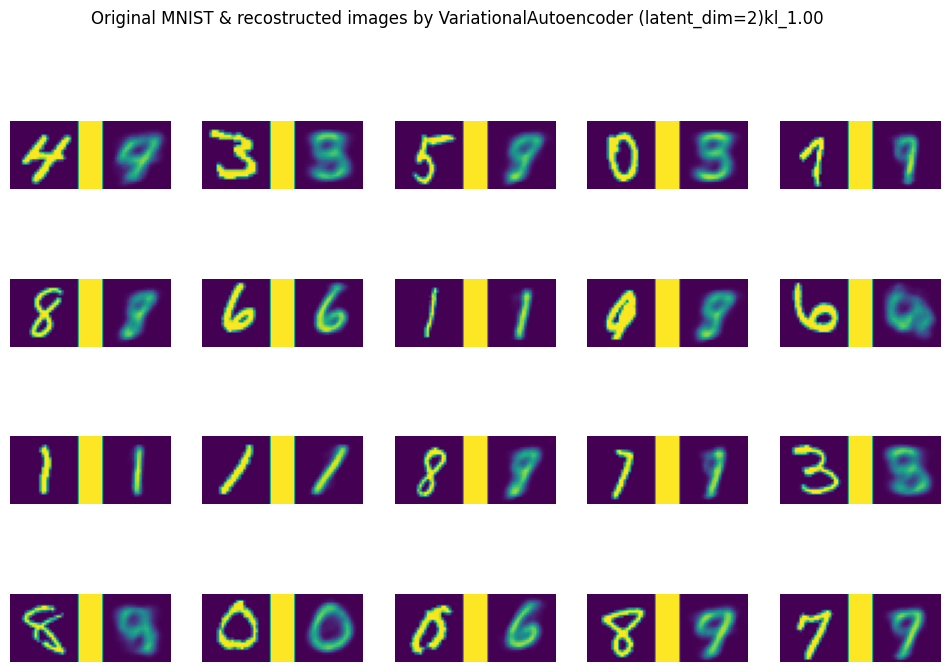

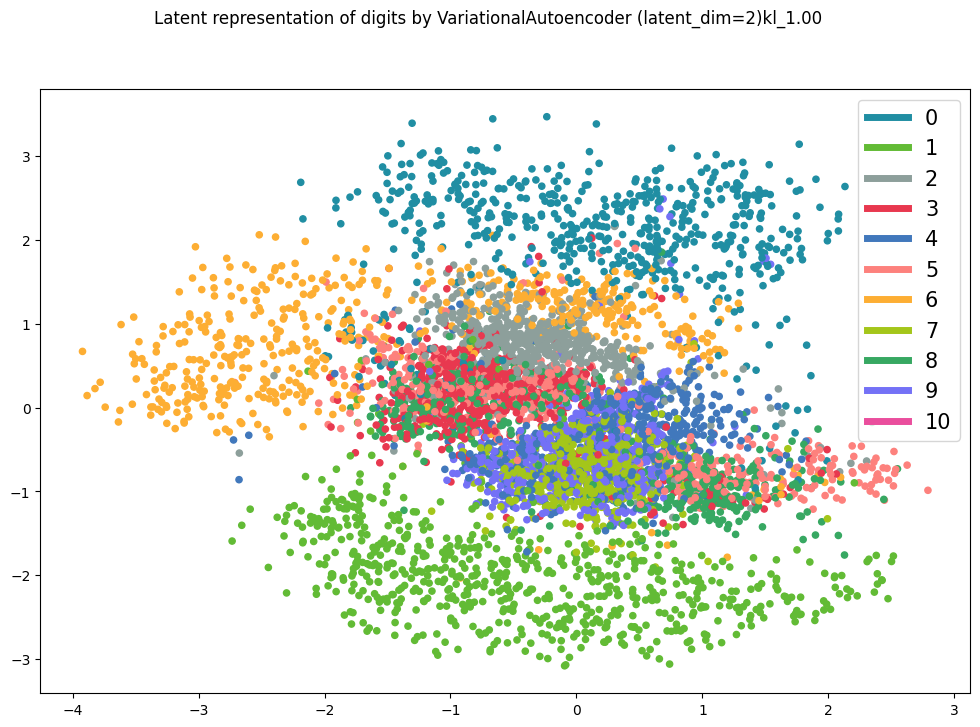

In [37]:
append_title=f"kl_{beta:.2f}"
vis_reconstructed_images(model_vae, append_title=append_title)
vis2D(model_vae, append_title=append_title)

We will generate random points in the latent space to see how the decoder can be used to generate data points.

In [40]:
def generate_data(model, append_title="", n_gen=20):
    n_gen = n_gen
    z = torch.randn((n_gen, model.latent_dim))
    
    with torch.no_grad():
        x_hat = model.decode(z)

    n_rows = 4
    n_cols = math.ceil(n_gen/n_rows)
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,8), dpi=100)
    for i in range(n_gen):
        ax = axs[i%n_rows, i//n_rows]
        ax.imshow(x_hat[i, :])
        ax.axis('off')
    
    title = f"{get_model_title(model)}{append_title}"
    _ = fig.suptitle(f"Decoded representations of random points in the latent space {title}")
    fig.savefig(f"images/rand_data_{title}.png")
    

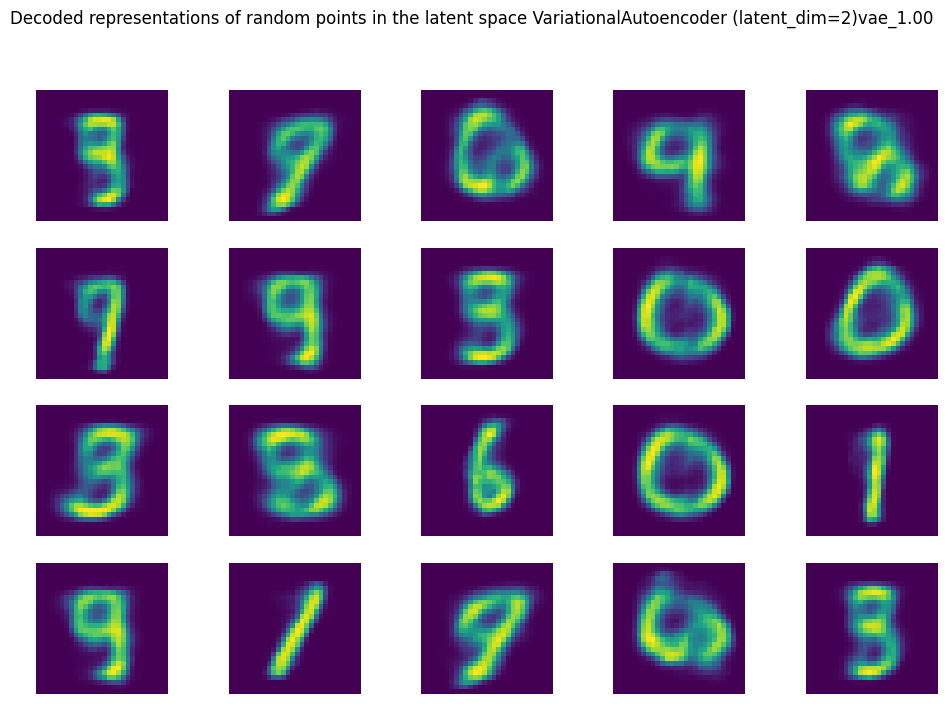

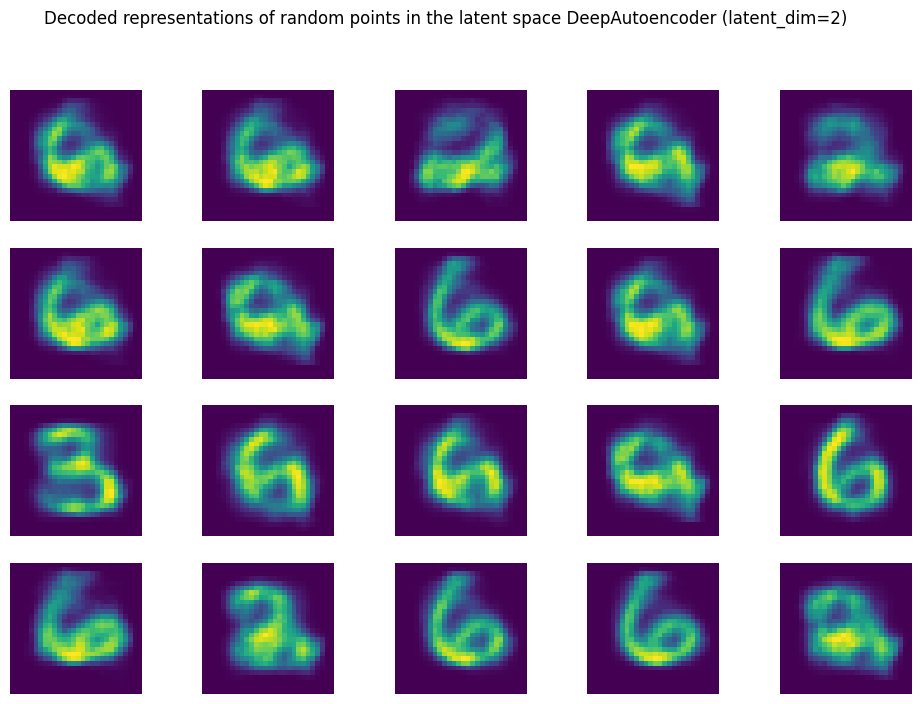

In [41]:
generate_data(model_vae, append_title=f"vae_{beta:0.2f}")
generate_data(model_deepae)

### Data Interpolation using VAE

Finally, we want to see how the interpolation results look like for different models. 
For this we will write a function to be called on different models.

In [42]:
# pick some pairs of datapoints from the dataset
n_interpolate = 5
idxs = rng.randint(len(data), size=(n_interpolate, 2))
dataset = Dataset(data)
in1 = torch.cat([dataset[idx][0].unsqueeze_(0) for idx in idxs[:, 0]], dim=0)
in2 = torch.cat([dataset[idx][0].unsqueeze_(0) for idx in idxs[:, 1]])

In [45]:
def interpolate(in1, in2, model, append_title=""):
    """
    Interpolates latent representations on `in1` and `in2`
    
    """
    alphas = np.arange(0, 1.01, 0.2)
    x_hats = []
    with torch.no_grad():
        z1 = model.encode(in1)
        z2 = model.encode(in2)
        for i, alpha in enumerate(alphas):
            z = (1- alpha) * z1 + alpha * z2
            x_hat = model.decode(z)
            x_hats.append(x_hat)
    
    # visualize
    fig, axs = plt.subplots(nrows=in1.shape[0], ncols=len(alphas) + 2, figsize=(12, 8), dpi=100)
    
    # plot originals 
    for j in range(in1.shape[0]):
        axs[j, 0].imshow(in1[j, :])
        axs[j, -1].imshow(in2[j, :])
        
        axs[j, 0].axis('off')
        axs[j, -1].axis('off')
    
    # plot decoded images
    for j in range(in1.shape[0]):
        for i, _ in enumerate(alphas):
            axs[j, i+1].imshow(x_hats[i][j, :])
            axs[j, i+1].axis('off')
    
    ## 
    title = f"{get_model_title(model)}{append_title}"
    _ = fig.suptitle(f"Data interpolation for {title}")
    fig.savefig(f"images/interpolated_{title}.png")
    

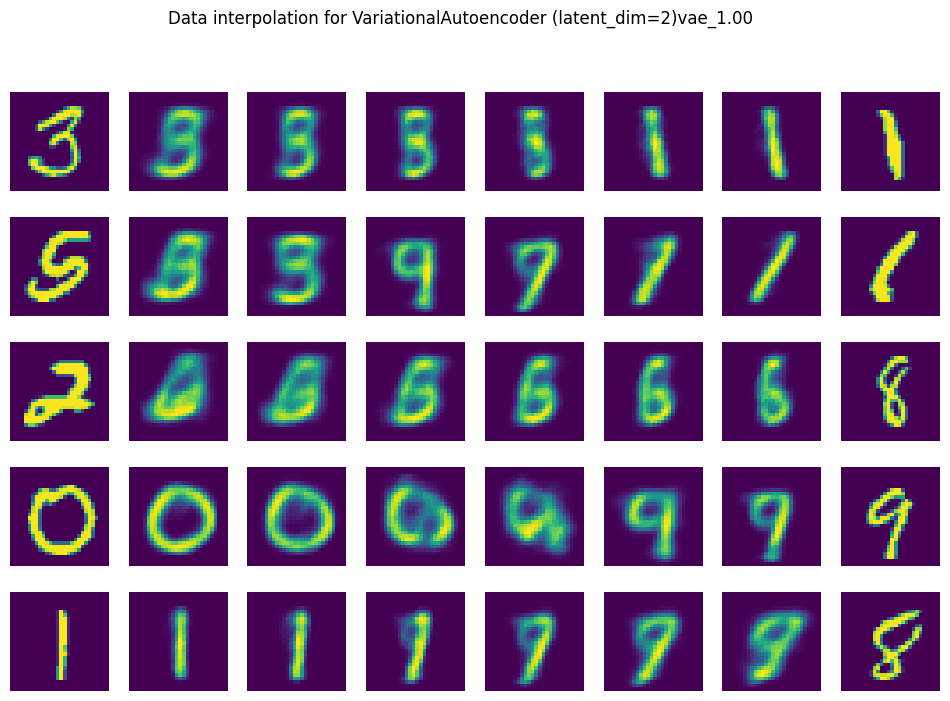

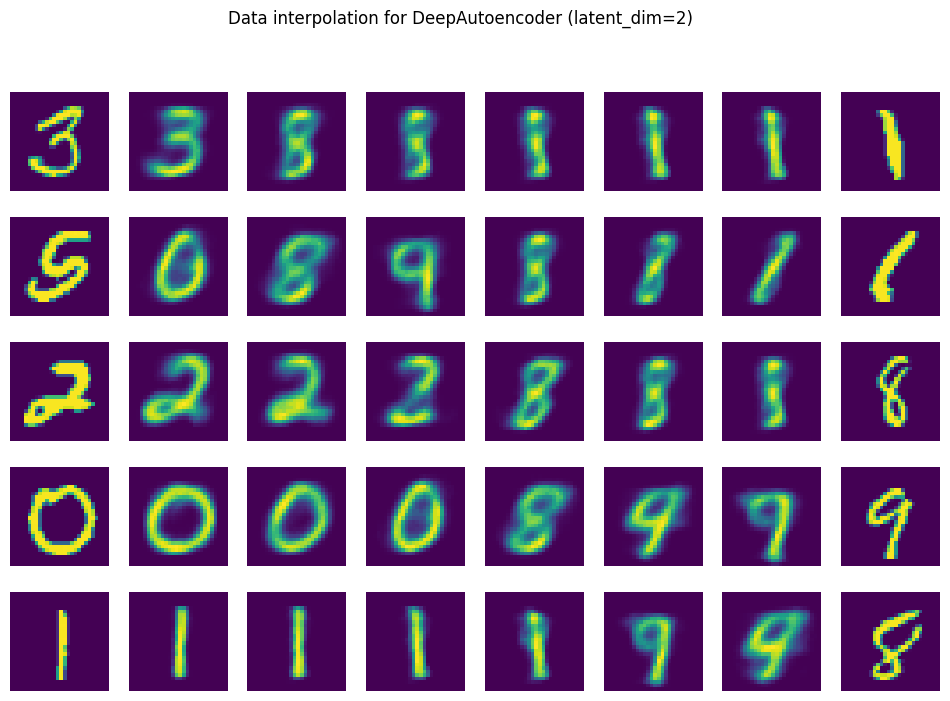

In [46]:
interpolate(in1, in2, model_vae, append_title=f"vae_{beta:.2f}")
interpolate(in1, in2, model_deepae)